## Installing the required packages

In [ ]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00


## Importing required libraries

In [ ]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')

## Preprocess the data

In [ ]:
import urllib.request
import zipfile
url = 'https://gitlab.com/shimorina/webnlg-dataset/-/archive/master/webnlg-dataset-master.zip?path=release_v3.0/en/train'
urllib.request.urlretrieve(url, 'web.zip')
with zipfile.ZipFile('web.zip', 'r') as zip_ref:
    zip_ref.extractall('web')
import glob
import os
import re
import xml.etree.ElementTree as ET
import pandas as pd
files = glob.glob("/content/web/webnlg-dataset-master-release_v3.0-en-train/release_v3.0/en/train/**/*.xml", recursive=True)
triple_re=re.compile('(\d)triples')
data_dct={}
for file in files:
    tree = ET.parse(file)
    root = tree.getroot()
    triples_num=int(triple_re.findall(file)[0])
    for sub_root in root:
        for ss_root in sub_root:
            strutured_master=[]
            unstructured=[]
            for entry in ss_root:
                unstructured.append(entry.text)
                strutured=[triple.text for triple in entry]
                strutured_master.extend(strutured)
            unstructured=[i for i in unstructured if i.replace('\n','').strip()!='' ]
            strutured_master=strutured_master[-triples_num:]
            strutured_master_str=(' && ').join(strutured_master)
            data_dct[strutured_master_str]=unstructured
mdata_dct={"prefix":[], "input_text":[], "target_text":[]}
for st,unst in data_dct.items():
    for i in unst:
        mdata_dct['prefix'].append('webNLG')
        mdata_dct['input_text'].append(st)
        mdata_dct['target_text'].append(i)


df=pd.DataFrame(mdata_dct)
df.to_csv('webNLG2020_train.csv')

In [ ]:
train_df=pd.read_csv('webNLG2020_train.csv', index_col=[0])

Trimming off a few data points and so that a batch would not leave any remainder, hence some lines of codes can be avoided (Okay, this might be a hackish way of doing it )

In [ ]:
train_df=train_df.iloc[  :35000,:]

In [ ]:
train_df=train_df.sample(frac = 1)

In [ ]:
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_epochs=4

In [ ]:
num_of_batches=int(num_of_batches)

Checking for the GPU availability

In [ ]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## Loading the pretrained model and tokenizer

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

## Initializing the Adafactor optimizer with parameter values suggested for t5

In [ ]:

optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

  






In [ ]:

from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [ ]:
num_of_epochs=1

## Training the model

In [ ]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
    
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.49695094069072177


## Plotting the loss over time

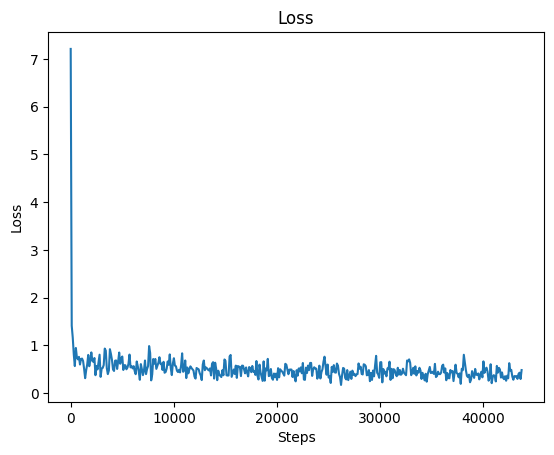

In [ ]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

## Testing the model

In [ ]:
model.eval()
input_ids = tokenizer.encode("WebNLG: sidharth | hometown | Delhi && sidharth | play |  football && sidharth | interests |  </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad>Sidharth, a footballer, is a city in Delhi and has'

Before testing the model further, lets learn how to serialize it and load from the path

In [ ]:
torch.save(model.state_dict(),'pytoch_model.bin')


In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/CS772/pytoch_model.bin')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

--2023-05-04 08:58:54--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.130.21, 52.217.64.78, 54.231.133.216, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.130.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1199 (1.2K) [application/json]
Saving to: ‘t5-base-config.json’

t5-base-config.json 100%[===================>]   1.17K  --.-KB/s    in 0s      

2023-05-04 08:58:55 (58.0 MB/s) - ‘t5-base-config.json’ saved [1199/1199]



In [ ]:
model = T5ForConditionalGeneration.from_pretrained('pytoch_model.bin', return_dict=True,config='t5-base-config.json')


In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/CS772/pytoch_model.bin')


In [ ]:
def generate(text):
  model.eval()
  input_ids = tokenizer.encode("WebNLG:{} </s>".format(text), return_tensors="pt")  # Batch size 1
  # input_ids.to(dev)
  s = time.time()
  outputs = model.generate(input_ids)
  gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  
  return gen_text

In [ ]:
import torch.quantization
import torch.nn as nn

quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear,nn.Dropout,nn.LayerNorm}, dtype=torch.qint8
)


In [ ]:
def quant_generate(text):
  quantized_model.eval()
  input_ids = tokenizer.encode("WebNLG:{} </s>".format(text), return_tensors="pt")  # Batch size 1
  # input_ids.to(dev)
  s = time.time()
  outputs = quantized_model.generate(input_ids)
  gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  
  return gen_text

In [ ]:
torch.save(quantized_model.state_dict(),'/content/drive/MyDrive/CS772/pytoch_small_model.bin')


In [ ]:
generate('Frederick Parker  && Born | 21 November 1914, Newington, Yorkshire && Died | 2 March 1987 (Aged 72) |')

Generated in 1.47 seconds


'Born in 1914, Newington, Yorkshire, Frederick Parker, died on the 2nd of March'

In [ ]:
generate('Charles III && Reign |	8 September 2022 – present && Predecessor | Elizabeth II && Heir apparent	| William, Prince of Wales && Born | Prince Charles of Edinburgh | 14 November 1948 (age 74) | Buckingham Palace, London, England && Spouses	|Diana Spencer (m. 1981; div. 1996)​| Camilla Parker Bowles (m. 2005)​')

tensor([[ 1620, 18207,   517,    10, 18947,   965,  6289,     3,   184,   184,
           419,  3191,  1820,   505,  1600,   460,  2884,     3,   104,   915,
             3,   184,   184,  1266,   221,    75, 24901,  1820,  9066,  2466,
             3,   184,   184,   216,    23,    52, 10320,  1820,  4599,     6,
          9027,    13, 10256,     3,   184,   184, 12896,  1820,  9027,  5417,
            13, 16504,  1820,   968,  1671, 21474,    41,   545,     3,  4581,
            61,  1820, 10295, 14799, 12530,     6,  1524,     6,  2789,     3,
           184,   184,  8927,  1074,     7,  1820,   308, 13662, 22577,    41,
            51,     5, 15465,   117,     3,  8481,     5,     3, 30841,  1820,
         28347,     9, 13156,  9713,    15,     7,    41,    51,     5,  3105,
            61,     1]])
Generated in 3.33 seconds


'The Predecessor of William, Prince of Wales was Elizabeth II. He was born in'

In [ ]:
generate('Charles III| Reign | 8 September 2022 – present && Charles III | Predecessor | Elizabeth II && Charles III | Heir apparent | William, Prince of Wales && Charles III | Born | Prince Charles of Edinburgh , 14 November 1948 (age 74) , Buckingham Palace, London, England && Charles III | Spouses	|Diana Spencer (m. 1981; div. 1996)​, Camilla Parker Bowles (m. 2005)​')

tensor([[ 1620, 18207,   517,    10, 18947,   965,  6289,  9175,   419,  3191,
          1820,   505,  1600,   460,  2884,     3,   104,   915,     3,   184,
           184,  5417,  6289,  1820,  1266,   221,    75, 24901,  1820,  9066,
          2466,     3,   184,   184,  5417,  6289,  1820,   216,    23,    52,
         10320,  1820,  4599,     6,  9027,    13, 10256,     3,   184,   184,
          5417,  6289,  1820, 12896,  1820,  9027,  5417,    13, 16504,     3,
             6,   968,  1671, 21474,    41,   545,     3,  4581,    61,     3,
             6, 10295, 14799, 12530,     6,  1524,     6,  2789,     3,   184,
           184,  5417,  6289,  1820,  8927,  1074,     7,  1820,   308, 13662,
         22577,    41,    51,     5, 15465,   117,     3,  8481,     5,     3,
         30841,     3,     6, 28347,     9, 13156,  9713,    15,     7,    41,
            51,     5,  3105,    61,     1]])
Generated in 4.18 seconds


'The Predecessor of Charles III was Elizabeth II. He was born in Edinburgh, 14'

In [ ]:
generate('Charles III| Reign | 8 September 2022 – present && Charles III | Predecessor | Elizabeth II ')

tensor([[ 1620, 18207,   517,    10, 18947,   965,  6289,  9175,   419,  3191,
          1820,   505,  1600,   460,  2884,     3,   104,   915,     3,   184,
           184,  5417,  6289,  1820,  1266,   221,    75, 24901,  1820,  9066,
          2466,     1]])
Generated in 1.23 seconds


'Elizabeth II was the Predecessor of Charles III, which was born on September 2022'

In [ ]:
generate('Charles III| rule | 8 September 2022 – present && Charles III | Predecessor | Elizabeth II ')

tensor([[ 1620, 18207,   517,    10, 18947,   965,  6289,  9175,  3356,  1820,
           505,  1600,   460,  2884,     3,   104,   915,     3,   184,   184,
          5417,  6289,  1820,  1266,   221,    75, 24901,  1820,  9066,  2466,
             1]])
Generated in 3.71 seconds


'Elizabeth II was the Predecessor of Charles III, which has the rule of 8 September'

In [ ]:
FeaturesDict({
    'input_text': FeaturesDict({
        'context': string,
        'table': Sequence({
            'column_header': string,
            'content': string,
            'row_number': int16,
        }),
    }),
})


In [ ]:
def generate(text):
  model.eval()
  input_ids = tokenizer.encode("WebNLG:{} </s>".format(text), return_tensors="pt")  # Batch size 1
  # input_ids.to(dev)
  s = time.time()
  outputs = model.generate(input_ids, max_length = 100)
  gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  
  return gen_text

In [ ]:
ans = generate('John_E_Blaha | birthDate | 1942_08_26 && John_E_Blaha |  birthPlace | San_Antonio && John_E_Blaha | occupation Fighter_pilot && ')

Generated in 2.88 seconds


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu('John_E_Blaha | birthDate | 1942_08_26 && John_E_Blaha |  birthPlace | San_Antonio && John_E_Blaha | occupation Fighter_pilot', ans)
print(score)

1.0659299031878216e-231


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
ans

' John E. Blaha was born in San Antonio on August 26, 1942. He was a fighter pilot.'

In [ ]:
ref = "Indus Valley Civilisation, also known as the Harappan Civilization, the ancient Indus, or the Indus civilization was a bronze age South Asia civilization in the basins of the Indus river, Pakistan and the seasonal Ghaggar-Hakra river, northwest India and eastern Pakistan. It was active during the years c. 3300 -  c.1300 BCE."

In [ ]:
ans = " The Indus Valley Civilisation (also known as Harappan civilization, ancient Indus civilization) has its c. 3300 - c.1300 BCE and its location is the Basin River, Pakistan and the regional Ghaggar-Hakra river, northwest India and eastern Pakistan."

In [ ]:
sentence_bleu([ref.split()], ans.split(), weights)

[0.30893390472038984, 0.24409708126846064, 0.1943248669636772]

In [ ]:
ref.split()
ans.split()

['Harry',
 'Potter',
 'is',
 'from',
 'the',
 'United',
 'Kingdom',
 'and',
 'was',
 'written',
 'by',
 'J.K.',
 'Rowling.',
 'The',
 'book',
 'is',
 'a',
 'fantasy',
 'genre',
 'and',
 'is',
 'written',
 'in',
 'English.']

In [ ]:
weights = [(1./2., 1./2.), (1./3., 1./3., 1./3.),(1./4., 1./4., 1./4., 1./4.)]